# Study 3. Predicción de series temporales (Otras funciones 'loss')

En este estudio voy a utilizar otras funciones de pérdida para ver si afecta a la métrica seleccionada al compilar el modelo neuronal.

### Carga de librerías

In [1]:
####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

Using TensorFlow backend.


In [2]:
import MyUtils as utils
print('Ready!')

Ready!


### Obtención del histórico de precios OHLC

In [3]:
# Cargo el histórico en el dataframe 'df' y visualizo los primeros registros
df = utils.load_hist('EURUSD_H1.csv', sep=';', remove_weekends=True)
df.head()


Deleting weekends...


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2001-01-01 01:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,60,0,5.0,0.0,50.0
2001-01-01 02:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,120,0,5.0,0.0,50.0
2001-01-01 03:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,180,0,5.0,0.0,50.0
2001-01-01 04:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,240,0,5.0,0.0,50.0
2001-01-01 05:00:00,0.9421,0.9423,0.9419,0.9419,0.942,0.942033,0.94205,0.0,300,0,5.0,0.0,50.0


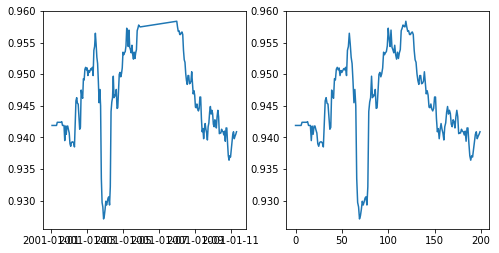

In [4]:
# Visualizo los 200 primeros datos del precio de cierre (CLOSE) de dos formas:
# Utilizando el eje x como fechas espaciadas de hora en hora (se ve un ajuste a mitad de gráfico debido a un fin de semana)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df.CLOSE[0:200])
# Utilizando los datos en bruto, con lo que dicha 'perturbación' ya no queda reflejada y por lo tanto podemos ver que los datos
# son válidos.
plt.subplot(1,2,2)
plt.plot(df.CLOSE.values[0:200])

### Indicadores técnicos

In [5]:
# Incluyo los indicadores técnicos más representativos y visualizo todas las columnas del nuevo dataframe 'df'
df = utils.add_indicators(df, applied=['HIGH','LOW'], base_cols=['OPEN','HIGH','LOW','CLOSE','OC2','HLC3','OHLC4'])
print(df.columns)
df.head(1)

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'OC2', 'HLC3', 'OHLC4',
       'IND_BB_UPPER_HIGH', 'IND_BB_MIDDLE_HIGH', 'IND_BB_LOWER_HIGH',
       'IND_BB_WIDTH_HIGH', 'IND_BB_PERCENT_HIGH', 'IND_BB_WIDTH_SMA4_HIGH',
       'IND_BB_WIDTH_SMA12_HIGH', 'IND_SMA4_HIGH', 'IND_SMA16_HIGH',
       'IND_SMA40_HIGH', 'IND_MACD_HIGH', 'IND_MACD_SIG_HIGH',
       'IND_MACD_HIST_HIGH', 'IND_RSI_HIGH', 'IND_APO_HIGH', 'IND_MOM_HIGH',
       'IND_ROCP_HIGH', 'IND_ROCR_HIGH', 'IND_BB_UPPER_LOW',
       'IND_BB_MIDDLE_LOW', 'IND_BB_LOWER_LOW', 'IND_BB_WIDTH_LOW',
       'IND_BB_PERCENT_LOW', 'IND_BB_WIDTH_SMA4_LOW', 'IND_BB_WIDTH_SMA12_LOW',
       'IND_SMA4_LOW', 'IND_SMA16_LOW', 'IND_SMA40_LOW', 'IND_MACD_LOW',
       'IND_MACD_SIG_LOW', 'IND_MACD_HIST_LOW', 'IND_RSI_LOW', 'IND_APO_LOW',
       'IND_MOM_LOW', 'IND_ROCP_LOW', 'IND_ROCR_LOW', 'IND_WILLR', 'IND_ATR',
       'IND_ATR_SMA4', 'IND_ATR_SMA12', 'IND_ADX', 'IND_ADXR', 'IND_CCI',
       'IND_SLOWK', 'IND_SLOWD'],
      dtype='object')


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ROCR_LOW,IND_WILLR,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD
2001-01-02 17:00:00,0.9474,0.9479,0.9451,0.9466,0.947,0.946533,0.94675,0.949573,0.94322,0.936867,...,1.007892,-20.535714,0.002487,0.002248,0.001847,26.239061,29.470872,93.474427,66.333333,44.572378


### Preparación de las salidas a predecir

In [6]:
# función para generar las salidas a predecir
def define_outputs(df):  
  df['OUT_HIGH'] = df.HIGH - df.CLOSE.shift(1)
  df['OUT_LOW'] = df.LOW - df.CLOSE.shift(1)
  return df

# Añado las salidas a predecir al dataframe 'df'
df = define_outputs(df)
df.dropna(inplace=True)
df.head()

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD,OUT_HIGH,OUT_LOW
2001-01-02 18:00:00,0.9465,0.9485,0.9456,0.9462,0.94635,0.946767,0.946700,0.950269,0.943540,0.936811,...,0.002517,0.002382,0.001960,25.946352,29.247257,87.328036,78.666667,62.401709,0.0019,-0.0010
2001-01-02 19:00:00,0.9464,0.9496,0.9455,0.9493,0.94785,0.948133,0.947700,0.951093,0.943875,0.936657,...,0.002630,0.002524,0.002076,26.008614,29.244717,110.866255,82.398754,75.799585,0.0034,-0.0007
2001-01-02 20:00:00,0.9493,0.9503,0.9482,0.9491,0.94920,0.949200,0.949225,0.951967,0.944295,0.936623,...,0.002592,0.002557,0.002167,26.273106,29.692141,129.569424,85.669816,82.245079,0.0010,-0.0011
2001-01-02 21:00:00,0.9489,0.9517,0.9486,0.9508,0.94985,0.950367,0.950000,0.953012,0.944790,0.936568,...,0.002628,0.002592,0.002236,26.912704,29.079180,154.054054,90.124362,86.064311,0.0026,-0.0005
2001-01-02 22:00:00,0.9506,0.9512,0.9492,0.9511,0.95085,0.950500,0.950525,0.953613,0.945405,0.937197,...,0.002584,0.002609,0.002297,27.506617,29.441555,137.467118,87.833135,87.875771,0.0004,-0.0016


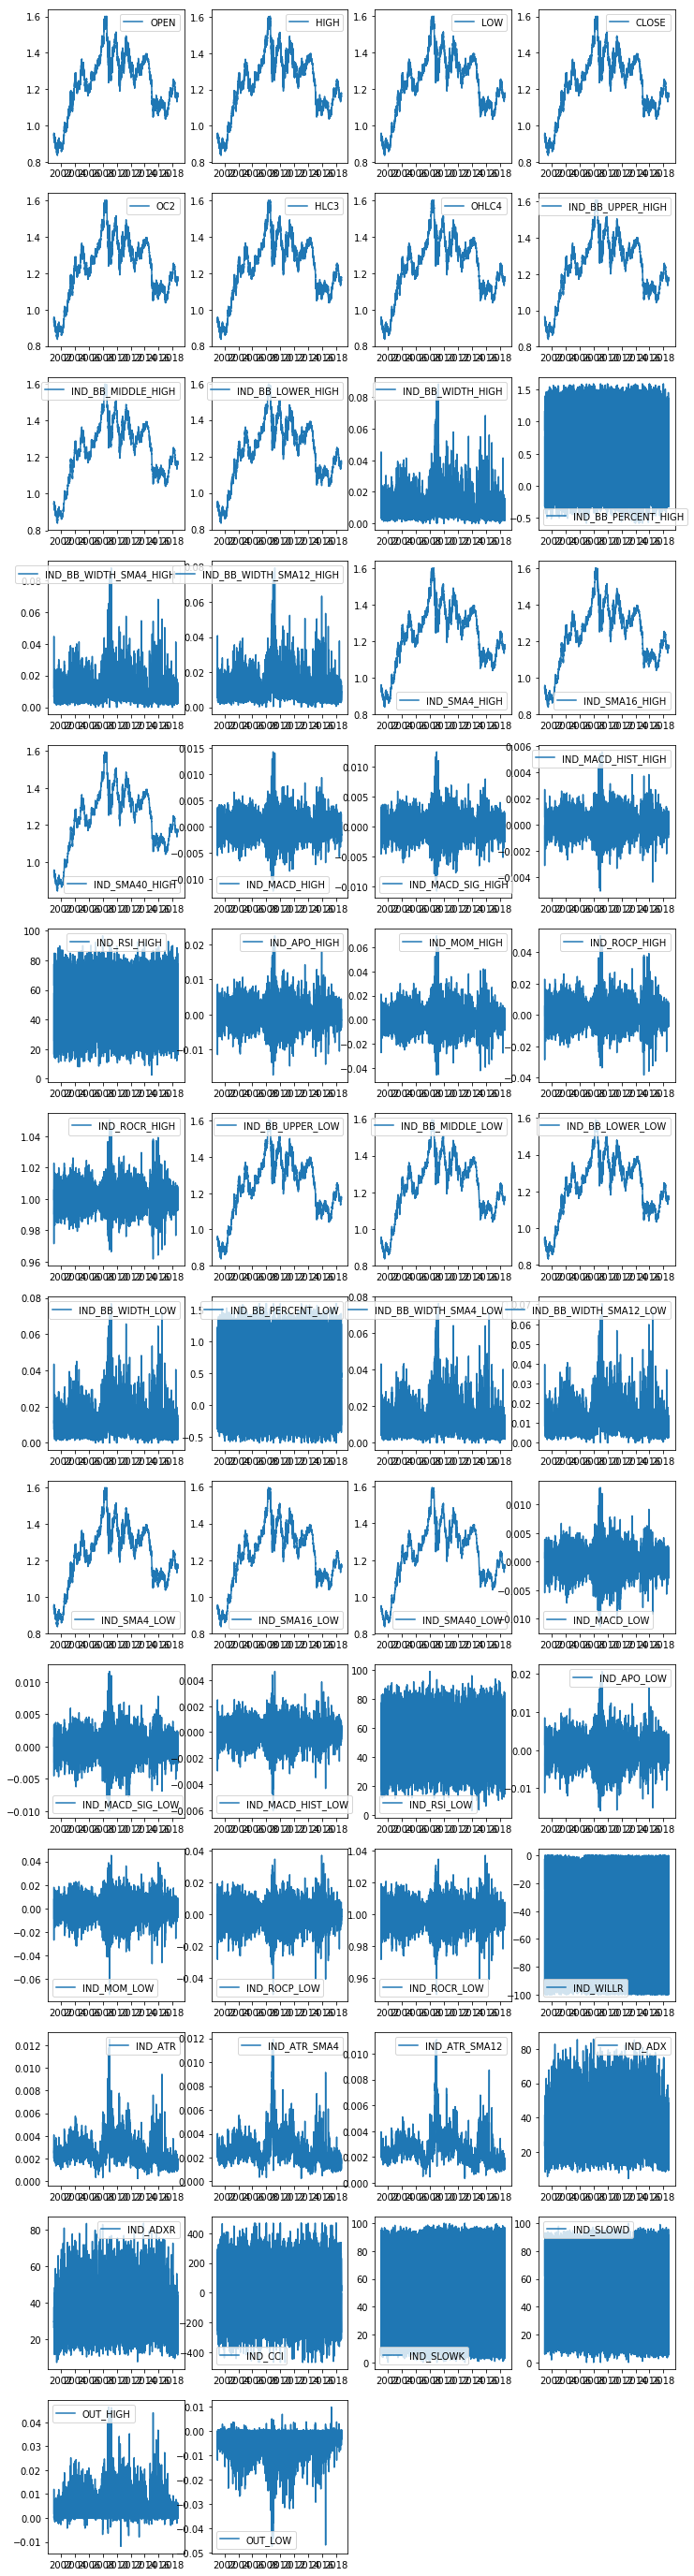

In [7]:
# Visualizo gráficamente todos los 'features' que forman el dataframe 'df', incluyendo las salidas a predecir
rows = (df.shape[1] / 4) + 1
plt.figure(figsize = (12,50))
for c in df.columns:
  i = df.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df[c])
  plt.legend([c])
  

### Adaptación de los datos al modelo neuronal

In [8]:
# Defino el formato del dataframe 'df_nn' que voy a obtener como proceso de adaptación. Es necesario definir las siguientes
# variables que se utilizarán a lo largo del desarrollo

# Número de salidas a predecir
num_outputs = 2

# Número de 'features' de entrada
num_inputs = len(df.columns) - num_outputs

# Número de timesteps previos
n_in = 4

# Número de timesteps a futuro
n_out = 1

# Flag para eliminar NaNs del dataframe resultante tras aplicar la adaptación
dropnan = True

# Procesa la adaptación al dataframe 'df' y genera un nuevo dataframe 'df_nn'
df_nn = utils.series_to_supervised(df, num_inputs, num_outputs, n_in, n_out, dropnan)
print(df_nn.shape)
df_nn.head()

(111075, 210)


,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2001-01-02 21:00:00,0.9465,0.9485,0.9456,0.9462,0.94635,0.946767,0.946700,0.950269,0.943540,0.936811,...,0.002628,0.002592,0.002236,26.912704,29.079180,154.054054,90.124362,86.064311,0.0004,-0.0016
2001-01-02 22:00:00,0.9464,0.9496,0.9455,0.9493,0.94785,0.948133,0.947700,0.951093,0.943875,0.936657,...,0.002584,0.002609,0.002297,27.506617,29.441555,137.467118,87.833135,87.875771,0.0008,-0.0005
2001-01-02 23:00:00,0.9493,0.9503,0.9482,0.9491,0.94920,0.949200,0.949225,0.951967,0.944295,0.936623,...,0.002492,0.002574,0.002349,28.259486,30.011312,126.970753,85.978739,87.978745,0.0007,-0.0001
2001-01-03 00:00:00,0.9489,0.9517,0.9486,0.9508,0.94985,0.950367,0.950000,0.953012,0.944790,0.936568,...,0.002371,0.002519,0.002392,28.958579,30.156251,101.740020,82.416085,85.409320,0.0003,-0.0017
2001-01-03 01:00:00,0.9506,0.9512,0.9492,0.9511,0.95085,0.950500,0.950525,0.953613,0.945405,0.937197,...,0.002345,0.002448,0.002429,28.762562,29.868250,68.501003,64.429771,77.608198,0.0014,-0.0002


In [9]:
# chequeo que la generación de las salidas a predecir es correcta mediante un dataframe temporal '_df' con las columnas más
# representativas. Verificaré que la columna 'next_high' coincide con 'HIGH(t)' desplazada 1 sesión en el futuro
_df = df_nn[['HIGH(t-1)','HIGH(t)','LOW(t-1)','LOW(t)','CLOSE(t-1)', 'CLOSE(t)','OUT_HIGH(t+1)']].head(10).copy()
_df['next_high'] = _df['CLOSE(t)']+ _df['OUT_HIGH(t+1)']
_df

,HIGH(t-1),HIGH(t),LOW(t-1),LOW(t),CLOSE(t-1),CLOSE(t),OUT_HIGH(t+1),next_high
2001-01-02 21:00:00,0.9503,0.9517,0.9482,0.9486,0.9491,0.9508,0.0004,0.9512
2001-01-02 22:00:00,0.9517,0.9512,0.9486,0.9492,0.9508,0.9511,0.0008,0.9519
2001-01-02 23:00:00,0.9512,0.9519,0.9492,0.9506,0.9511,0.9507,0.0007,0.9514
2001-01-03 00:00:00,0.9519,0.9514,0.9506,0.9506,0.9507,0.9510,0.0003,0.9513
2001-01-03 01:00:00,0.9514,0.9513,0.9506,0.9493,0.9510,0.9498,0.0014,0.9512
2001-01-03 02:00:00,0.9513,0.9512,0.9493,0.9496,0.9498,0.9506,0.0009,0.9515
2001-01-03 03:00:00,0.9512,0.9515,0.9496,0.9497,0.9506,0.9503,0.0012,0.9515
2001-01-03 04:00:00,0.9515,0.9515,0.9497,0.9499,0.9503,0.9506,0.0005,0.9511
2001-01-03 05:00:00,0.9515,0.9511,0.9499,0.9504,0.9506,0.9509,0.0003,0.9512
2001-01-03 06:00:00,0.9511,0.9512,0.9504,0.9502,0.9509,0.9507,0.0011,0.9518


### Normalización de los datos

A la hora de utilizar los datos como entrada del modelo neuronal, es necesario que todos estén en el mismo factor de escala o que tengan valores en un rango similar, de forma que facilite el entrenamiento del modelo.

Para ello utilizo la librería 'sklearn' con el scaler 'MinMaxScaler' que permite reajustar diferentes conjuntos de datos de una sola vez.

El 'scaler' resultante deberé guardarlo para reutilizarlo en el proceso inverso de de-normalización, para obtener los valores reales predichos.

In [10]:
#### Normalización de los datos sobre el datafram 'df_nn'. Genero un nuevo dataframe 'dfnorm'
dfnorm, scaler = utils.normalize_data(df_nn)
# Verifico los datos del nuevo dataframe generado
dfnorm.describe()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
count,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,...,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000,111075.000000
mean,0.033865,0.033231,0.035218,0.033863,0.034959,0.035154,0.035238,0.038386,0.037107,0.033320,...,-0.623475,-0.606744,-0.589015,-0.241417,-0.260166,0.002245,0.001109,0.001118,-0.548019,0.615988
std,0.417065,0.416516,0.417317,0.416953,0.417604,0.417516,0.417565,0.419489,0.419828,0.416751,...,0.169775,0.177401,0.189264,0.344248,0.329896,0.237714,0.460994,0.426412,0.062081,0.063146
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.239546,-0.239932,-0.237981,-0.239496,-0.238786,-0.238531,-0.238480,-0.235436,-0.238737,-0.240259,...,-0.738342,-0.727204,-0.717670,-0.505740,-0.508426,-0.171889,-0.378991,-0.344841,-0.578315,0.607300
50%,0.091002,0.090056,0.092336,0.091004,0.092141,0.092404,0.092442,0.096924,0.095168,0.089239,...,-0.648404,-0.632089,-0.615080,-0.296453,-0.311962,0.004566,0.006319,0.006717,-0.564591,0.633269
75%,0.324540,0.322937,0.326707,0.324455,0.326141,0.326145,0.326316,0.327138,0.329468,0.324913,...,-0.549768,-0.529226,-0.506308,-0.026229,-0.057786,0.176273,0.381178,0.348127,-0.540573,0.647658
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3 Construcción del modelo neuronal

### Validación cruzada

Utilizaré el dataframe normalizado 'dfnorm' para dividirlo en pares de entrada-salida (X,Y). Generaré 5 conjuntos con sendos modelos neuronales formados por:

- 3 capas LSTM con 64 neuronas por capa.
- 1 capa Dense intermedia con 128 neuronas.
- 1 capa Dense de salida con 2 neuronas (una por salida)

In [13]:
# split into input (X) and output (Y) variables
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
# define 10-fold cross validation test harness
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
losses = ['mse','mae','mape','msle', 'squared_hinge', 'hinge', 'logcosh', 'kullback_leibler_divergence', 'poisson', 'cosine_proximity']
i=0
for train, test in kfold.split(X, Y):
  # create model
  model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128, 'weights_2811.3_m'+str(i)+'.hd5', loss=losses[i], metrics=['accuracy'])
  i += 1
  # Fit the model
  x = X[train]
  x = x.reshape(x.shape[0], n_in, num_inputs)
  utils.fit(model, x, Y[train], num_inputs, n_in, num_epochs=2, callbacks=callbacks, batchsize=32)  
  # evaluate the model
  x = X[test]
  scores = utils.test_evaluation(model, x, Y[test], num_inputs, n_in)
  x = x.reshape(x.shape[0], n_in, num_inputs)
  scores = model.evaluate(x, Y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/2
 - 19s - loss: 0.0046 - acc: 0.9996
Epoch 2/2


C:\Users\raulm\Programas\anaconda3\envs\keras\lib\site-packages\keras\callbacks.py:434: RuntimeWarning:

Can save best model only with val_acc available, skipping.



 - 17s - loss: 0.0037 - acc: 0.9998
loss: 0.43%
acc: 99.97%
Epoch 1/2
 - 19s - loss: 0.0334 - acc: 0.9996
Epoch 2/2
 - 17s - loss: 0.0305 - acc: 0.9997
loss: 3.33%
acc: 99.98%
Epoch 1/2
 - 20s - loss: 15.7812 - acc: 0.9997
Epoch 2/2
 - 18s - loss: 15.8645 - acc: 0.9997
loss: 1224.54%
acc: 99.99%
Epoch 1/2
 - 20s - loss: 0.0010 - acc: 0.9995
Epoch 2/2
 - 19s - loss: 8.6435e-04 - acc: 0.9997
loss: 0.10%
acc: 99.98%
Epoch 1/2
 - 21s - loss: 0.0082 - acc: 0.9995
Epoch 2/2
 - 18s - loss: 0.0053 - acc: 0.9998
loss: 0.75%
acc: 99.97%
Epoch 1/2
 - 20s - loss: 0.0072 - acc: 0.9994
Epoch 2/2
 - 18s - loss: 0.0039 - acc: 0.9997
loss: 0.30%
acc: 99.98%
Epoch 1/2
 - 21s - loss: 0.0023 - acc: 0.9995
Epoch 2/2
 - 18s - loss: 0.0018 - acc: 0.9998
loss: 0.19%
acc: 99.95%
Epoch 1/2
 - 21s - loss: -2.9090e-01 - acc: 0.9996
Epoch 2/2
 - 18s - loss: -2.9481e-01 - acc: 0.9998
loss: -29.53%
acc: 99.95%
Epoch 1/2
 - 21s - loss: nan - acc: 0.0022
Epoch 2/2
 - 19s - loss: nan - acc: 2.4008e-04
loss: nan%
acc: 0

Voy a seleccionar loss='mae' como función de pérdidas en este estudio.

### Entrenamiento del modelo

In [14]:
# Preparo los conjuntos de entrenamiento y validación en una proporción del 80-20
x_train,y_train,x_test,y_test = utils.prepare_training_data(dfnorm, num_inputs * n_in, 0.8)
print('x_train:', x_train.shape, 'y_train', y_train.shape)
print('x_test:', x_test.shape, 'y_test', y_test.shape)


x_train: (88860, 208) y_train (88860, 2)
x_test: (22215, 208) y_test (22215, 2)


In [17]:
# Creo el mismo modelo neuronal utilizado durante la validación  cruzada
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'weights_study_3.hd5',loss='mae',verbose=1)

No weights file to load
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 4, 64)             29952     
_________________________________________________________________
dropout_40 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 4, 64)             33024     
_________________________________________________________________
dropout_41 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_42 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)            

Train on 71088 samples, validate on 17772 samples
Epoch 1/10
 - 18s - loss: 0.0378 - acc: 0.9996 - val_loss: 0.0273 - val_acc: 1.0000
Epoch 2/10
 - 15s - loss: 0.0335 - acc: 0.9997 - val_loss: 0.0247 - val_acc: 1.0000
Epoch 3/10
 - 15s - loss: 0.0333 - acc: 0.9997 - val_loss: 0.0256 - val_acc: 1.0000
Epoch 4/10
 - 15s - loss: 0.0331 - acc: 0.9997 - val_loss: 0.0247 - val_acc: 1.0000
Epoch 5/10
 - 15s - loss: 0.0331 - acc: 0.9997 - val_loss: 0.0247 - val_acc: 1.0000
Epoch 6/10
 - 15s - loss: 0.0328 - acc: 0.9997 - val_loss: 0.0249 - val_acc: 1.0000
Epoch 7/10
 - 15s - loss: 0.0328 - acc: 0.9997 - val_loss: 0.0246 - val_acc: 1.0000
Epoch 8/10
 - 15s - loss: 0.0328 - acc: 0.9997 - val_loss: 0.0245 - val_acc: 1.0000
Epoch 9/10
 - 15s - loss: 0.0327 - acc: 0.9997 - val_loss: 0.0246 - val_acc: 1.0000
Epoch 10/10
 - 15s - loss: 0.0326 - acc: 0.9997 - val_loss: 0.0243 - val_acc: 1.0000


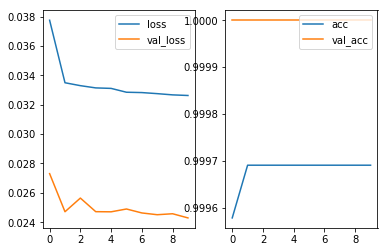

In [18]:
# Realizo el proceso de entrenamiento durante un número de épocas.
num_epochs = 10
# Tamaño del batch para la actualización de pesos
batchsize = 32
# Utilizo un 20% de los datos para realizar una validación
val_ratio = 0.2
# Cojo datos de forma aleatoria durante la fase de entrenamiento
shuffle = True
# Flag para visualizar los resultados al final del proceso
plot_results = True
# Función para iniciar el entrenamiento
result = utils.fit(model, x_train, y_train, num_inputs, n_in, num_epochs, callbacks, batchsize, val_ratio, shuffle, plot_results)

In [19]:
# Guardo los pesos en un archivo HDF5
model.save_weights('weights_study_3.hd5')

### Verificación del modelo

Model Loss:  0.023239403815519533
Model Accuracy:  0.9997749268512266


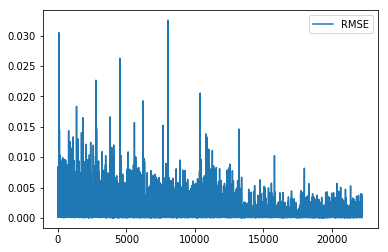

In [20]:
# Evaluación del modelo con la partición de test. Utilizo callback para formar las salidas reales
ih = df_nn.columns.get_loc('OUT_HIGH(t+1)')  
il = df_nn.columns.get_loc('OUT_LOW(t+1)')
ic = df_nn.columns.get_loc('CLOSE(t)')
  
def out_builder(xy,xyhat):
  return np.asarray([xy[ih]+xy[ic],xy[il]+xy[ic]]), np.asarray([xyhat[ih]+xyhat[ic],xyhat[il]+xyhat[ic]])
  
scores, targets, preds, rmse = utils.test_rmse(model, x_test, y_test, num_inputs, n_in, num_outputs, n_out, scaler, out_builder, True)

In [21]:
# obtengo los resultados como arrays
atgt = np.asarray(targets)
apreds = np.asarray(preds)
armse = np.asarray(rmse)

# creo un nuevo dataframe de resultados 'df_predict'
df_predict = df_nn[x_train.shape[0]:].copy()
#... al que añado las predicciones hechas...
df_predict['PREDICT_HIGH'] = apreds[:,0]
df_predict['PREDICT_LOW'] = apreds[:,1]

#... los objetivos que debería haber predicho...
df_predict['TARGET_HIGH'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)'] 

#... unas columnas para chequear que los objetivos son correctos
df_predict['TARGET_HIGH_CHECK'] = atgt[:,0]
df_predict['TARGET_LOW_CHECK'] = atgt[:,1]

#... el error RMSE
df_predict['RMSE'] = armse[:]

df_predict.head()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1),PREDICT_HIGH,PREDICT_LOW,TARGET_HIGH,TARGET_LOW,TARGET_HIGH_CHECK,TARGET_LOW_CHECK,RMSE
2015-03-13 09:00:00,1.06137,1.06138,1.06009,1.06040,1.060885,1.060623,1.060810,1.066305,1.062948,1.059591,...,28.416810,0.00234,-0.00081,1.062002,1.058855,1.06343,1.06028,1.06343,1.06028,0.001427
2015-03-13 10:00:00,1.06039,1.06061,1.05960,1.06001,1.060200,1.060073,1.060153,1.066328,1.062933,1.059538,...,42.222676,-0.00001,-0.00266,1.062636,1.059931,1.06183,1.05918,1.06183,1.05918,0.000779
2015-03-13 11:00:00,1.05999,1.05999,1.05644,1.05788,1.058935,1.058103,1.058575,1.066444,1.062833,1.059221,...,60.998242,0.00042,-0.00294,1.061510,1.059258,1.06123,1.05787,1.06123,1.05787,0.001001
2015-03-13 12:00:00,1.05787,1.06169,1.05716,1.06109,1.059480,1.059980,1.059452,1.066261,1.062695,1.059129,...,64.600223,0.00096,-0.00189,1.059046,1.056623,1.05912,1.05627,1.05912,1.05627,0.000255
2015-03-13 13:00:00,1.06112,1.06343,1.06028,1.06184,1.061480,1.061850,1.061667,1.064946,1.062450,1.059954,...,53.732409,0.00315,-0.00013,1.057607,1.055085,1.05983,1.05655,1.05983,1.05655,0.001882


Con el nuevo dataframe de resultado 'df_predict', realizo una visualización para ver cómo se ha comportado el modelo.

Visualizaré un rango de datos (i:j) de los objetivos H,L buscados y las predicciones reales generadas. El área entre los objetivos H-L se rellenerá en color gris, mientras que el área de las predicciones se rellenará en amarillo.

De esta forma, se puede ver claramente, si el rango de predicción es correcto y está alineado con el objetivo.

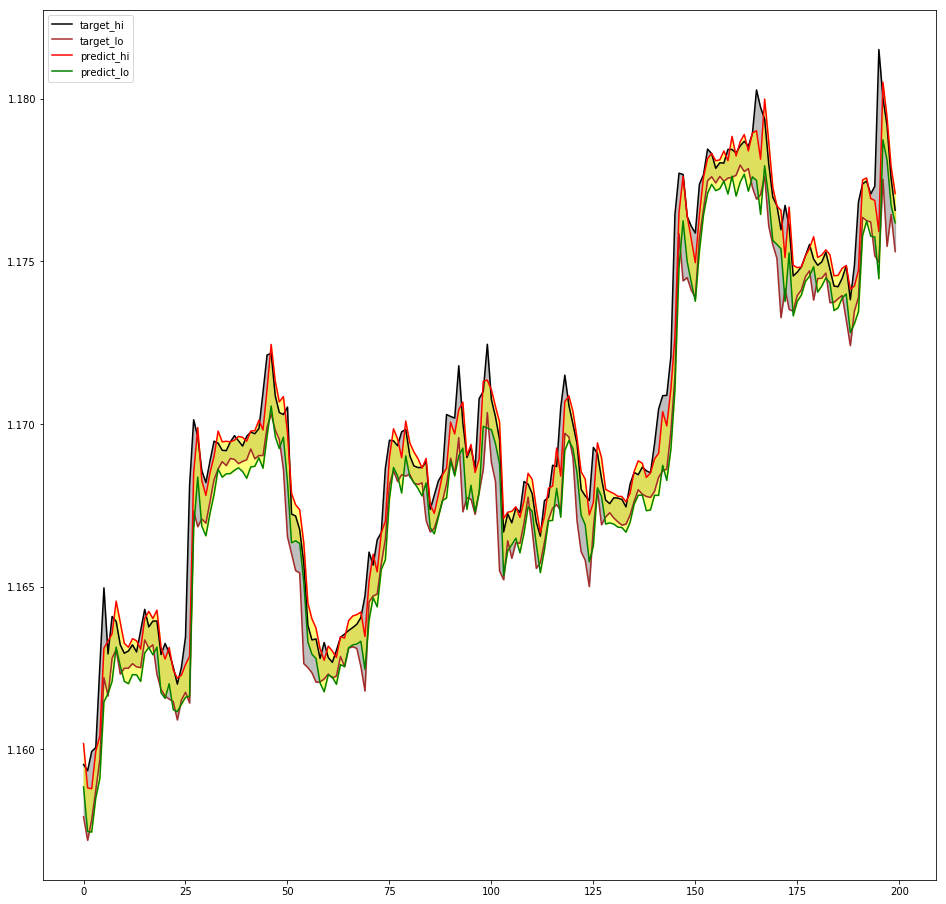

In [23]:
plt.figure(figsize=(16,16))
i,j=-300,-100
x = np.arange(j-i)
y1 = df_predict['TARGET_HIGH'].values[i:j]
y2 = df_predict['TARGET_LOW'].values[i:j]
y3 = df_predict['PREDICT_HIGH'].values[i:j]
y4 = df_predict['PREDICT_LOW'].values[i:j]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])


## 4 Conclusiones


Al utilizar como función de pérdidas la función 'mae', los resultados son mejores que en la solución original, ya que los rangos predichos son muy parecidos a los objetivos.